In [92]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
import matplotlib.pyplot as plt
import forestplot as fp

In [2]:
icd_features_file = "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/discovery/icd_features.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]
cohort_file = "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british/discovery/cohort_pheno.csv.gz"

In [3]:
icd_features_df = pd.read_csv(icd_features_file, index_col=0)
icd_features_df.index = icd_features_df.index.astype(str)

In [6]:
cohort_df = pd.read_csv(cohort_file, usecols=["sample_names", "bmi_prs", "bmi", "bmi_residuals", "carrier"], dtype={"sample_names": str})

In [31]:
cohort_df["bmi_prs_decile"] = pd.qcut(cohort_df.bmi_prs, 10, labels=False)
cohort_df["bmi_decile"] = pd.qcut(cohort_df.bmi, 10, labels=False)
cohort_df["bmi_residuals_decile"] = pd.qcut(cohort_df.bmi_residuals, 10, labels=False)

In [10]:
combo_samples = set(cohort_df.loc[cohort_df.carrier==True, "sample_names"].values)
noncombo_samples = set(cohort_df.loc[cohort_df.carrier==False, "sample_names"].values)

In [11]:
combo_features_df = icd_features_df.loc[icd_features_df.index.isin(combo_samples)]
noncombo_features_df = icd_features_df.loc[icd_features_df.index.isin(noncombo_samples)]

In [17]:
def divide_into_nocomorbidity(features_df):
    no_comorbidity_df = features_df.loc[features_df.sum(axis=1)==0]
    comorbidity_df = features_df.loc[features_df.sum(axis=1)>0]
    return comorbidity_df, no_comorbidity_df

def cluster_by_comorbidity(train_features_df, test_features_df):
    train_comorbidity_df, train_no_comorbidity_df = divide_into_nocomorbidity(train_features_df)
    test_comorbidity_df, test_no_comorbidity_df = divide_into_nocomorbidity(test_features_df)
    train_no_comorbidity_df["labels"] = 0
    test_no_comorbidity_df["labels"] = 0
    no_comorbidity_df = pd.concat((train_no_comorbidity_df, test_no_comorbidity_df))

    X_train, X_test = train_comorbidity_df.values, test_comorbidity_df.values
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    y_train = kmeans.fit_predict(X_train)
    y_test = kmeans.fit_predict(X_test)
    
    train_comorbidity_df["labels"] = y_train
    test_comorbidity_df["labels"] = y_test
    comorbidity_df = pd.concat((train_comorbidity_df, test_comorbidity_df))
    comorbidity_df["labels"] = comorbidity_df.labels.replace(0, 2)
    icd_df = pd.concat((comorbidity_df, no_comorbidity_df))
    return icd_df

In [18]:
icd_df = cluster_by_comorbidity(noncombo_features_df, combo_features_df)

/tmp/ipykernel_33735/1137769198.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_comorbidity_df["labels"] = 0
/tmp/ipykernel_33735/1137769198.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_no_comorbidity_df["labels"] = 0
/tmp/ipykernel_33735/1137769198.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [35]:
cohort_info_df = cohort_df.merge(icd_df.loc[:, "labels"].to_frame(), left_on="sample_names", right_index=True)

In [36]:
cohort_info_df["bmi_prs_hue"] = cohort_info_df.bmi_prs_decile.map({
    0: "low", 1: "middle", 
    2: "middle", 3: "middle", 4:"middle", 5: "middle", 6: "middle", 7:"middle",
    8: "middle", 9: "high"})

In [48]:
cohort_info_df

,sample_names,bmi_prs,bmi,bmi_residuals,carrier,bmi_prs_decile,bmi_decile,bmi_residuals_decile,labels,bmi_prs_hue
0,1000028,-0.652309,25.50385,-0.408359,False,3,3,3,1,middle
1,1000045,-1.084330,23.71090,-0.462484,False,1,2,3,1,middle
2,1000171,-0.980411,30.92310,0.985810,False,2,7,8,0,middle
3,1000196,0.032952,19.57480,-1.554883,False,5,0,0,1,middle
4,1000222,0.092755,30.00600,0.292562,False,6,7,6,2,middle
...,...,...,...,...,...,...,...,...,...,...
383248,6024818,-0.416108,27.60950,-0.045320,False,4,5,5,1,middle
383249,6024948,0.321514,47.22080,3.942332,False,7,9,9,2,middle
383250,6025016,-1.162700,26.56900,-0.024413,True,1,4,5,1,middle
383251,6025181,-0.119517,26.49910,-0.211799,False,5,4,4,0,middle


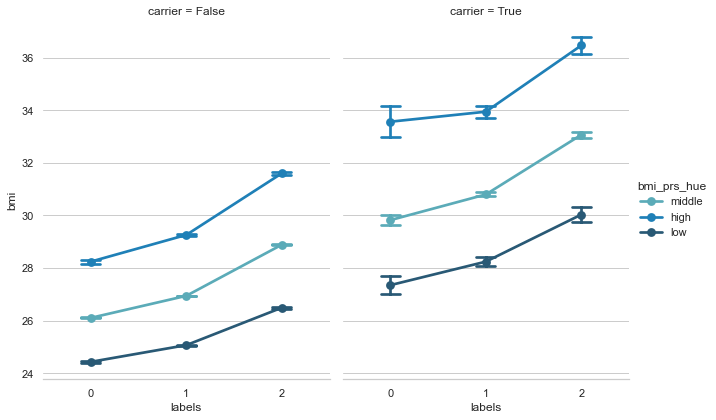

In [56]:
# Draw a pointplot to show pulse as a function of three categorical factors
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=cohort_info_df, x="labels", y="bmi", hue="bmi_prs_hue", col="carrier",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)


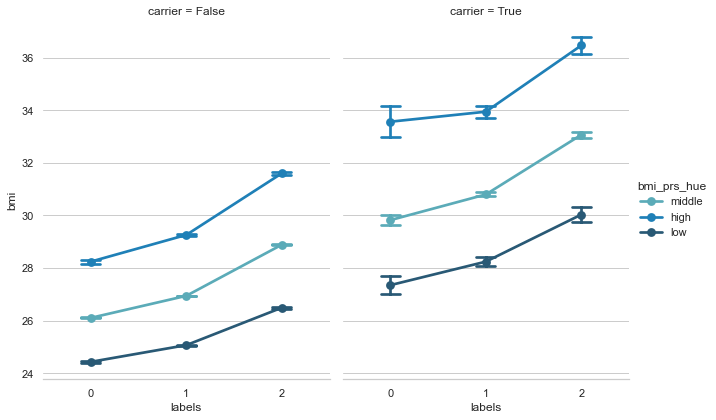

In [107]:
g.figure

In [57]:
cohort_info_df.set_index("sample_names")

,sample_names,bmi_prs,bmi,bmi_residuals,carrier,bmi_prs_decile,bmi_decile,bmi_residuals_decile,labels,bmi_prs_hue
0,1000028,-0.652309,25.50385,-0.408359,False,3,3,3,1,middle
1,1000045,-1.084330,23.71090,-0.462484,False,1,2,3,1,middle
2,1000171,-0.980411,30.92310,0.985810,False,2,7,8,0,middle
3,1000196,0.032952,19.57480,-1.554883,False,5,0,0,1,middle
4,1000222,0.092755,30.00600,0.292562,False,6,7,6,2,middle
...,...,...,...,...,...,...,...,...,...,...
383248,6024818,-0.416108,27.60950,-0.045320,False,4,5,5,1,middle
383249,6024948,0.321514,47.22080,3.942332,False,7,9,9,2,middle
383250,6025016,-1.162700,26.56900,-0.024413,True,1,4,5,1,middle
383251,6025181,-0.119517,26.49910,-0.211799,False,5,4,4,0,middle


In [73]:
def prepare_polynomial_features(data_df, features, y_var, include_bias):
    feature_df = data_df.loc[:, features].dropna()
    X = feature_df.values
    poly = PolynomialFeatures(len(features), interaction_only=True, include_bias=include_bias)
    X_poly = poly.fit_transform(X)
    y = data_df.loc[data_df.index.isin(feature_df.index), y_var].values.reshape(-1,1)
    return X_poly,y, poly.get_feature_names_out(input_features=features)[1:]

def train_model_sm(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    r2 = results.rsquared
    coefs = results.params[1:]
    conf_ints = results.conf_int()[1:]
    p_vals = results.pvalues[1:]
    return r2, coefs, conf_ints, p_vals

In [74]:
X_poly, y, poly_features = prepare_polynomial_features(cohort_info_df, ["carrier", "bmi_prs", "labels"], "bmi", True)

In [75]:
r2, coefs, conf_ints, p_vals = train_model_sm(X_poly, y)

In [84]:
r2, coefs, conf_ints, p_vals

(0.1307262822185734,
 array([ 3.76549573,  0.99865936,  1.51684763,  0.63241671,  0.21674231,
         0.24799741, -0.13788201]),
 array([[ 3.55654811,  3.97444335],
        [ 0.96791746,  1.02940126],
        [ 1.49350515,  1.54019011],
        [ 0.42580648,  0.83902694],
        [ 0.06383859,  0.36964602],
        [ 0.22457998,  0.27141484],
        [-0.29016944,  0.01440542]]),
 array([7.68634007e-273, 0.00000000e+000, 0.00000000e+000, 1.98339788e-009,
        5.46511272e-003, 1.20537482e-095, 7.59697922e-002]))

In [88]:
poly_features

array(['carrier', 'bmi_prs', 'labels', 'carrier bmi_prs',
       'carrier labels', 'bmi_prs labels', 'carrier bmi_prs labels'],
      dtype=object)

In [90]:
df_data = np.concatenate([poly_features.reshape(-1,1), coefs.reshape(-1,1), conf_ints, p_vals.reshape(-1,1)], axis=1)

coef_df = pd.DataFrame(df_data, columns=["variables", "coefs", "ci_low", "ci_high", "p_value"])

In [91]:
coef_df

,variables,coefs,ci_low,ci_high,p_value
0,carrier,3.765496,3.556548,3.974443,0.0
1,bmi_prs,0.998659,0.967917,1.029401,0.0
2,labels,1.516848,1.493505,1.54019,0.0
3,carrier bmi_prs,0.632417,0.425806,0.839027,0.0
4,carrier labels,0.216742,0.063839,0.369646,0.005465
5,bmi_prs labels,0.247997,0.22458,0.271415,0.0
6,carrier bmi_prs labels,-0.137882,-0.290169,0.014405,0.07597


In [80]:
for pf, cf, pval in zip(poly_features, coefs, p_vals):
    print(pf, cf, pval)

carrier 3.765495730578214 7.68634007369663e-273
bmi_prs 0.9986593578456201 0.0
labels 1.5168476299198936 0.0
carrier bmi_prs 0.632416710091803 1.98339787513843e-09
carrier labels 0.21674230533702502 0.005465112724505204
bmi_prs labels 0.24799741070630904 1.20537482330619e-95
carrier bmi_prs labels -0.13788201066060282 0.07596979219420436


In [103]:
def create_odds_ratio_plot(df, figsize=(6,3)):
    fig = fp.forestplot(
        df,  # the dataframe with results data
        estimate="coefs",  # col containing estimated effect size 
        ll="ci_low", hl="ci_high",
        pval="p_value",
        decimal_precision=3,
        varlabel="variables",  # column containing variable label
        color_alt_rows=True,
        table=True,
        annote=["est_ci"],
        annoteheaders=["Est. (95% Conf. Int.)"],
        # group ordering
        sort=True, # sort in ascending order (sorts within group if group is specified)
        ylabel="Est. (95% Conf. Int.)",  # y-label title
        xlabel="Model Coefficients",  # x-label title
        xticks=[-0.5, 0, 0.5, 1, 5],
        figsize=figsize,
        **{"marker": "D",  # set maker symbol as diamond
            "markersize": 75,  # adjust marker size
            "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
            "xlinecolor": "k",  # gray color for x-reference line
            "xline": 0,
            "xlinewidth": 1,
            "xtick_size": 12,  # adjust x-ticker fontsize
            "lw": 3,
            "thresholds": (0.001, 0.01, 0.05),
            }       
        )
    return fig

In [104]:
coef_df["variables"] = coef_df.variables.str.replace(" ", "*")

<AxesSubplot: xlabel='Model Coefficients', ylabel='Est. (95% Conf. Int.)'>

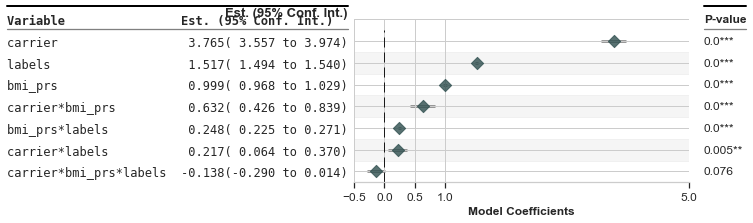

In [105]:
create_odds_ratio_plot(coef_df)

<AxesSubplot: xlabel='labels', ylabel='bmi'>

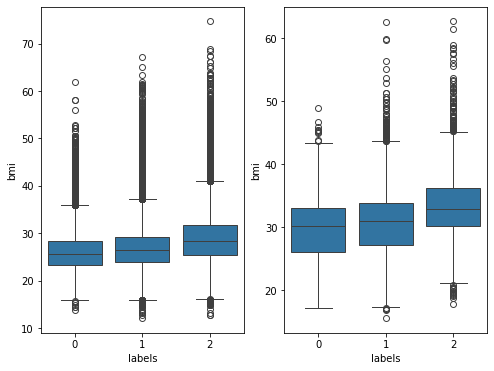

In [43]:
fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.boxplot(cohort_info_df.loc[cohort_info_df.carrier==False], x="labels", y="bmi", ax=ax[0])
sns.boxplot(cohort_info_df.loc[cohort_info_df.carrier==True], x="labels", y="bmi", ax=ax[1])

<AxesSubplot: xlabel='labels', ylabel='bmi_residuals'>

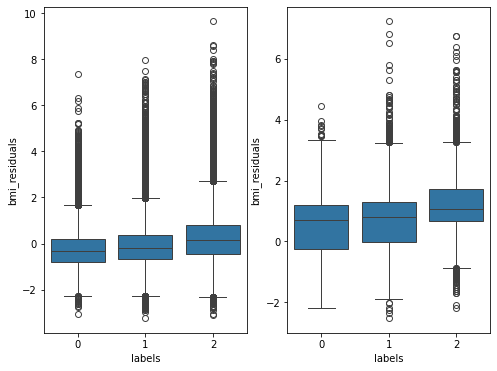

In [44]:
fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.boxplot(cohort_info_df.loc[cohort_info_df.carrier==False], x="labels", y="bmi_residuals", ax=ax[0])
sns.boxplot(cohort_info_df.loc[cohort_info_df.carrier==True], x="labels", y="bmi_residuals", ax=ax[1])

<AxesSubplot: xlabel='labels', ylabel='bmi'>

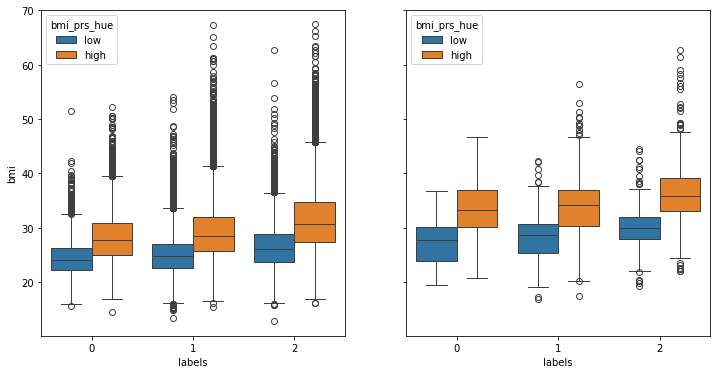

In [49]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)
sns.boxplot(cohort_info_df.loc[cohort_info_df.carrier==False], x="labels", y="bmi", hue="bmi_prs_hue", hue_order=["low", "high"], ax=ax[0])
sns.boxplot(cohort_info_df.loc[cohort_info_df.carrier==True], x="labels", y="bmi", hue="bmi_prs_hue", hue_order=["low", "high"], ax=ax[1])

<AxesSubplot: xlabel='labels', ylabel='bmi_residuals'>

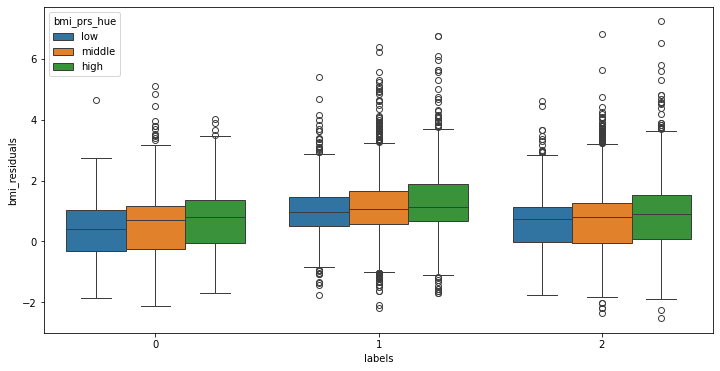

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
sns.boxplot(icd_df, x="labels", y="bmi_residuals", hue="bmi_prs_hue", hue_order=["low", "middle", "high"], ax=ax)

In [58]:
icd_df.loc[(icd_df.labels==0)&(icd_df.bmi_prs_hue=="low"), ["bmi", "bmi_residuals", "bmi_prs"]].describe()

,bmi,bmi_residuals,bmi_prs
count,350.000000,350.000000,350.000000
mean,27.465001,0.418335,-1.576861
std,4.240355,0.882132,0.513788
min,16.546200,-1.864087,-3.497380
25%,23.910975,-0.302371,-1.882955
50%,27.422950,0.368868,-1.409780
75%,30.422700,1.031131,-1.179538
max,48.352500,4.641790,-0.994209


In [56]:
icd_df.loc[(icd_df.labels==0)&(icd_df.bmi_prs_hue=="low")&(icd_df.bmi_residuals>0)]

,BlockB95-B98,BlockD10-D36,BlockD50-D53,BlockD60-D64,BlockE00-E07,BlockE10-E14,BlockE15-E16,BlockE65-E68,BlockE70-E90,BlockF30-F39,...,BlockZ40-Z54,BlockZ80-Z99,labels,sample_names,bmi_prs,bmi,bmi_residuals,bmi_prs_decile,bmi_decile,bmi_prs_hue
325582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,5050629,-1.95052,32.5489,1.403246,0,6,low
136133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,3978613,-1.87117,29.7973,0.994729,0,3,low
28441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2678861,-1.04578,32.7089,1.381906,1,6,low
92591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1402786,-1.29244,27.4309,0.267393,1,2,low
412396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,5128854,-2.51968,29.1049,0.897457,0,3,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2290052,-1.14687,31.6263,1.229744,1,5,low
359735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2024477,-1.16899,30.8365,0.917591,1,4,low
295313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,3274491,-1.10740,30.3211,0.980040,1,4,low
59354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,4475675,-1.50197,27.1739,0.318106,0,2,low


<AxesSubplot: xlabel='labels', ylabel='bmi_prs'>

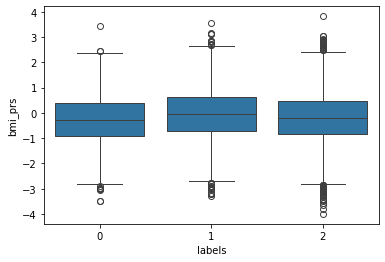

In [21]:
sns.boxplot(icd_df, x="labels", y="bmi_prs")

In [27]:
icd_df.loc[icd_df.labels==2, icd_features_df.columns].sum(axis=1).mean()

4.1268379096545615

In [29]:
icd_df.loc[icd_df.labels==1, icd_features_df.columns].sum(axis=1).mean()

13.379449294828744

In [30]:
icd_features_df

,BlockB95-B98,BlockD10-D36,BlockD50-D53,BlockD60-D64,BlockE00-E07,BlockE10-E14,BlockE15-E16,BlockE65-E68,BlockE70-E90,BlockF30-F39,...,BlockR10-R19,BlockR25-R29,BlockR30-R39,BlockR40-R46,BlockR50-R69,BlockT80-T88,BlockV10-V19,BlockZ00-Z13,BlockZ40-Z54,BlockZ80-Z99
samples,,,,,,,,,,,,,,,,,,,,,
1000867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1000880,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001565,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1001799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4678011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1828525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
icd_features_df.columns

Index(['BlockB95-B98', 'BlockD10-D36', 'BlockD50-D53', 'BlockD60-D64',
       'BlockE00-E07', 'BlockE10-E14', 'BlockE15-E16', 'BlockE65-E68',
       'BlockE70-E90', 'BlockF30-F39', 'BlockG40-G47', 'BlockG50-G59',
       'BlockG60-G64', 'BlockH80-H83', 'BlockI10-I15', 'BlockI20-I25',
       'BlockI30-I52', 'BlockJ09-J18', 'BlockJ20-J22', 'BlockJ40-J47',
       'BlockK20-K31', 'BlockK55-K64', 'BlockK70-K77', 'BlockK80-K87',
       'BlockL00-L08', 'BlockL40-L45', 'BlockM05-M14', 'BlockM15-M19',
       'BlockM20-M25', 'BlockM45-M49', 'BlockM50-M54', 'BlockM70-M79',
       'BlockN17-N19', 'BlockN30-N39', 'BlockN80-N98', 'BlockR00-R09',
       'BlockR10-R19', 'BlockR25-R29', 'BlockR30-R39', 'BlockR40-R46',
       'BlockR50-R69', 'BlockT80-T88', 'BlockV10-V19', 'BlockZ00-Z13',
       'BlockZ40-Z54', 'BlockZ80-Z99'],
      dtype='object')

In [31]:
icd_df.labels.value_counts()

labels
2    5645
1    2978
0    1570
Name: count, dtype: int64

Text(0.5, 1.0, 'visualize comorbidity trend')

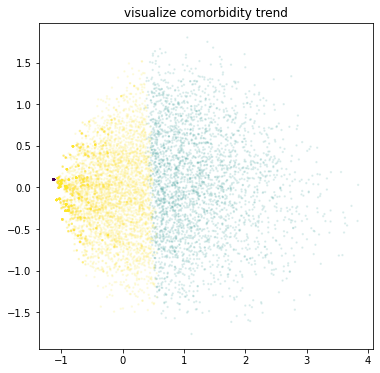

In [38]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(icd_features_df.values)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

axs.scatter(reduced_data[:, 0], reduced_data[:, 1], c=icd_df.labels, s=2, alpha=0.1)
axs.set_title("visualize comorbidity trend")

In [30]:
icd_df

,BlockB95-B98,BlockD10-D36,BlockD50-D53,BlockD60-D64,BlockE00-E07,BlockE10-E14,BlockE15-E16,BlockE65-E68,BlockE70-E90,BlockF30-F39,...,BlockR25-R29,BlockR30-R39,BlockR40-R46,BlockR50-R69,BlockT80-T88,BlockV10-V19,BlockZ00-Z13,BlockZ40-Z54,BlockZ80-Z99,labels
samples,,,,,,,,,,,,,,,,,,,,,
1000867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
1000880,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1001486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1001565,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1001799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4678011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1828525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
